# Task 2 - Binary Classifier

In [69]:
import numpy as np
import seaborn as sns
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
df_train = pd.read_csv("binary_classifier_data/training.csv", delimiter=';')
df_test = pd.read_csv("binary_classifier_data/validation.csv", delimiter=';')

### Explore the Dataset

In [71]:
df_train.head()

,variable1,variable2,variable3,variable4,variable5,variable6,variable7,variable8,variable9,variable10,variable11,variable12,variable13,variable14,variable15,variable17,variable18,variable19,classLabel
0,a,"17,92","5,4e-05",u,g,c,v,"1,75",f,t,1,t,g,80.0,5,800000.0,t,0,no.
1,b,"16,92","3,35e-05",y,p,k,v,"0,29",f,f,0,f,s,200.0,0,2000000.0,NaN,0,no.
2,b,"31,25","0,0001125",u,g,ff,ff,0,f,t,1,f,g,96.0,19,960000.0,t,0,no.
3,a,"48,17","0,0001335",u,g,i,o,"0,335",f,f,0,f,g,0.0,120,0.0,NaN,0,no.
4,b,"32,33","0,00035",u,g,k,v,"0,5",f,f,0,t,g,232.0,0,2320000.0,f,0,no.


In [72]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3700 entries, 0 to 3699
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   variable1   3661 non-null   object 
 1   variable2   3661 non-null   object 
 2   variable3   3700 non-null   object 
 3   variable4   3636 non-null   object 
 4   variable5   3636 non-null   object 
 5   variable6   3634 non-null   object 
 6   variable7   3634 non-null   object 
 7   variable8   3700 non-null   object 
 8   variable9   3700 non-null   object 
 9   variable10  3700 non-null   object 
 10  variable11  3700 non-null   int64  
 11  variable12  3700 non-null   object 
 12  variable13  3700 non-null   object 
 13  variable14  3600 non-null   float64
 14  variable15  3700 non-null   int64  
 15  variable17  3600 non-null   float64
 16  variable18  1555 non-null   object 
 17  variable19  3700 non-null   int64  
 18  classLabel  3700 non-null   object 
dtypes: float64(2), int64(3), ob

See proportions of classLabel, whether the dataset is imbalanced or not

In [73]:
count_no = df_train[df_train['classLabel']=='no.'].count()[0]
count_yes = df_train[df_train['classLabel']=='yes.'].count()[0]
print(f"Yes: {(count_yes/df_train.shape[0])*100}")
print(f"No: {(count_no/df_train.shape[0])*100}")

Yes: 91.67567567567568
No: 7.270270270270271


> As we can see that the data is highly imbalanced, so accuracy score won't a good metric for the model, instead I'll be using confusion matrix, precision, recall, and F1 score

### Data Preprocessing

Variable 18 will be dropped as more than half of the data it is missing

In [74]:
df_train.drop(['variable18'], axis=1, inplace=True)
df_test.drop(['variable18'], axis=1, inplace=True)

Prepare some columns to be converted to floats

In [75]:
def replace_comma(x):
    return re.sub(',', '.', str(x))

v = ['variable2', 'variable3', 'variable8']

for col in v:
    df_train[col] = df_train[col].apply(replace_comma)
    df_test[col] = df_test[col].apply(replace_comma)
    
df_train.head(2)

,variable1,variable2,variable3,variable4,variable5,variable6,variable7,variable8,variable9,variable10,variable11,variable12,variable13,variable14,variable15,variable17,variable19,classLabel
0,a,17.92,5.4e-05,u,g,c,v,1.75,f,t,1,t,g,80.0,5,800000.0,0,no.
1,b,16.92,3.35e-05,y,p,k,v,0.29,f,f,0,f,s,200.0,0,2000000.0,0,no.


In [76]:
#Change the datatype to float
for col in v:
    df_train[col] = df_train[col].astype(float)
    df_test[col] = df_test[col].astype(float)
    
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3700 entries, 0 to 3699
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   variable1   3661 non-null   object 
 1   variable2   3661 non-null   float64
 2   variable3   3700 non-null   float64
 3   variable4   3636 non-null   object 
 4   variable5   3636 non-null   object 
 5   variable6   3634 non-null   object 
 6   variable7   3634 non-null   object 
 7   variable8   3700 non-null   float64
 8   variable9   3700 non-null   object 
 9   variable10  3700 non-null   object 
 10  variable11  3700 non-null   int64  
 11  variable12  3700 non-null   object 
 12  variable13  3700 non-null   object 
 13  variable14  3600 non-null   float64
 14  variable15  3700 non-null   int64  
 15  variable17  3600 non-null   float64
 16  variable19  3700 non-null   int64  
 17  classLabel  3700 non-null   object 
dtypes: float64(5), int64(3), object(10)
memory usage: 520.4+ KB


#### Missing Values
> Missing Categorical values will be replaced by the most-frequent.

In [77]:
categ_var = [1, 4, 5, 6, 7, 9, 10, 12, 13]

for var in categ_var:
    df_train['variable'+str(var)].fillna(df_train['variable'+str(var)].mode()[0], inplace=True)
    df_test['variable'+str(var)].fillna(df_test['variable'+str(var)].mode()[0], inplace=True)

> Missing Numerical values will be replaced with the median.

In [78]:
df_train.fillna(df_train.median(), inplace=True)
df_test.fillna(df_test.median(), inplace=True)

In [79]:
#check for null values again
print(df_train.isnull().any())
print(df_test.isnull().any())

variable1     False
variable2     False
variable3     False
variable4     False
variable5     False
variable6     False
variable7     False
variable8     False
variable9     False
variable10    False
variable11    False
variable12    False
variable13    False
variable14    False
variable15    False
variable17    False
variable19    False
classLabel    False
dtype: bool
variable1     False
variable2     False
variable3     False
variable4     False
variable5     False
variable6     False
variable7     False
variable8     False
variable9     False
variable10    False
variable11    False
variable12    False
variable13    False
variable14    False
variable15    False
variable17    False
variable19    False
classLabel    False
dtype: bool


### See the correlation between columns

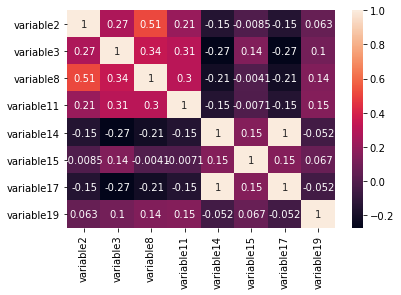

In [80]:
sns.heatmap(df_train.corr(), annot=True)

> Notice that variable17 is just variable14 but multiplied by a number, so we are going to drop variable17 column

In [81]:
df_train.drop(['variable17'], axis=1, inplace=True)
df_test.drop(['variable17'], axis=1, inplace=True)

### Encoding Categorical variables

In [82]:
X_cat = df_train[['variable1', 'variable4', 'variable5', 'variable6', 'variable7', 'variable9', 'variable10', 'variable12', 'variable13']]
X_cat.head()

,variable1,variable4,variable5,variable6,variable7,variable9,variable10,variable12,variable13
0,a,u,g,c,v,f,t,t,g
1,b,y,p,k,v,f,f,f,s
2,b,u,g,ff,ff,f,t,f,g
3,a,u,g,i,o,f,f,f,g
4,b,u,g,k,v,f,f,t,g


In [83]:
df_train['classLabel'] = df_train['classLabel'].map({'no.': 0, 'yes.': 1})
df_test['classLabel'] = df_test['classLabel'].map({'no.': 0, 'yes.': 1})
df_train['classLabel']

0       0
1       0
2       0
3       0
4       0
       ..
3695    1
3696    1
3697    1
3698    1
3699    1
Name: classLabel, Length: 3700, dtype: int64

In [84]:
df_train.head(2)

,variable1,variable2,variable3,variable4,variable5,variable6,variable7,variable8,variable9,variable10,variable11,variable12,variable13,variable14,variable15,variable19,classLabel
0,a,17.92,0.000054,u,g,c,v,1.75,f,t,1,t,g,80.0,5,0,0
1,b,16.92,0.000034,y,p,k,v,0.29,f,f,0,f,s,200.0,0,0,0


In [85]:
cols = ['variable1', 'variable4', 'variable5', 'variable6', 'variable7', 'variable9', 'variable10', 'variable12', 'variable13']

X_all = pd.concat([df_train, df_test], keys=[0,1])
df_tmp = pd.get_dummies(X_all, columns=cols)
df_train = df_tmp.xs(0)
df_test = df_tmp.xs(1)
df_train.shape

(3700, 48)

In [86]:
df_y_train = df_train['classLabel']
df_y_test = df_test['classLabel']

y_train = df_train['classLabel'].values
y_test = df_test['classLabel'].values

df_train = df_train.drop(['classLabel'], axis=1)
df_test = df_test.drop(['classLabel'], axis=1)
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [87]:
X_train = df_train.values
X_test = df_test.values
X_test

array([[3.233e+01, 7.500e-04, 1.585e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [2.358e+01, 1.790e-04, 5.400e-01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [3.642e+01, 7.500e-05, 5.850e-01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [3.083e+01, 0.000e+00, 1.250e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.967e+01, 3.750e-05, 2.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [3.017e+01, 6.500e-04, 3.125e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00]])

### Feature Scaling

In [88]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_test

array([[0.2793985 , 0.26785714, 0.05561404, ..., 0.        , 0.        ,
        1.        ],
       [0.14781955, 0.06392857, 0.01894737, ..., 1.        , 0.        ,
        0.        ],
       [0.34090226, 0.02678571, 0.02052632, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.25684211, 0.        , 0.04385965, ..., 1.        , 0.        ,
        0.        ],
       [0.08902256, 0.01339286, 0.07017544, ..., 1.        , 0.        ,
        0.        ],
       [0.24691729, 0.23214286, 0.10964912, ..., 1.        , 0.        ,
        0.        ]])

### Logistic Regression

In [149]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [150]:
y_pred

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [151]:
from sklearn.metrics import confusion_matrix, classification_report

print("Accuracy {} %".format( 100 * accuracy_score(y_pred, y_test)))
print("Recall {} %".format( 100 * recall_score(y_pred, y_test)))
print("Precision {} %".format( 100 * precision_score(y_pred, y_test)))
print("F1-score {} %".format( 100 * f1_score(y_pred, y_test)))

Accuracy 77.0 %
Recall 67.93893129770993 %
Precision 95.6989247311828 %
F1-score 79.46428571428572 %


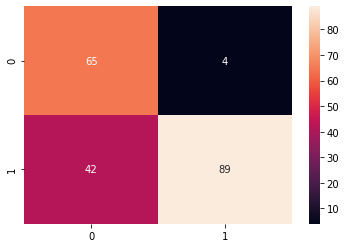

In [152]:
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True)

In [153]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.61      0.74       107
           1       0.68      0.96      0.79        93

    accuracy                           0.77       200
   macro avg       0.81      0.78      0.77       200
weighted avg       0.82      0.77      0.76       200



### Random Forest

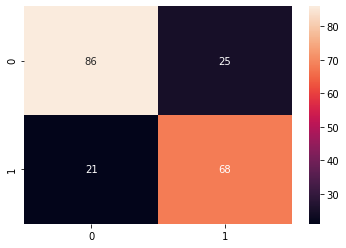

In [154]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=10, random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True)

In [155]:
print("Accuracy {} %".format( 100 * accuracy_score(y_pred, y_test)))
print("Recall {} %".format( 100 * recall_score(y_pred, y_test)))
print("Precision {} %".format( 100 * precision_score(y_pred, y_test)))
print("F1-score {} %".format( 100 * f1_score(y_pred, y_test)))

Accuracy 77.0 %
Recall 76.40449438202246 %
Precision 73.11827956989248 %
F1-score 74.72527472527474 %


### KNN

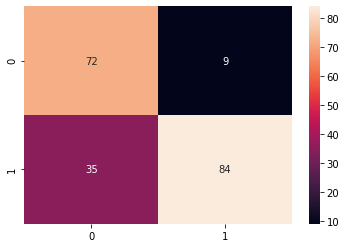

In [156]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True)

In [157]:
print("Accuracy {} %".format( 100 * accuracy_score(y_pred, y_test)))
print("Recall {} %".format( 100 * recall_score(y_pred, y_test)))
print("Precision {} %".format( 100 * precision_score(y_pred, y_test)))
print("F1-score {} %".format( 100 * f1_score(y_pred, y_test)))

Accuracy 78.0 %
Recall 70.58823529411765 %
Precision 90.32258064516128 %
F1-score 79.24528301886792 %


### Linear Discriminant Analysis (LDA)

In [158]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

In [159]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

Accuracy 77.0 %
Recall 67.93893129770993 %
Precision 95.6989247311828 %
F1-score 79.46428571428572 %


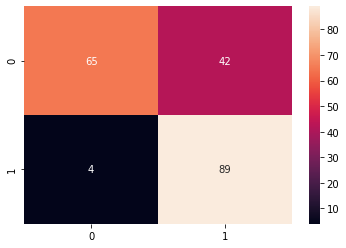

In [161]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
#print(cm)
sns.heatmap(cm, annot=True)
print("Accuracy {} %".format( 100 * accuracy_score(y_pred, y_test)))
print("Recall {} %".format( 100 * recall_score(y_pred, y_test)))
print("Precision {} %".format( 100 * precision_score(y_pred, y_test)))
print("F1-score {} %".format( 100 * f1_score(y_pred, y_test)))

## Conclusion

The metrics I focused on were the precision, recall, and f1-score and not accuracy as the data was highly imbalance